In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import timeit
import random

In [2]:
class yapay_sinir_agi():
    def __init__(self, katmanlar):
        self.katmanlar = katmanlar
        self.b = [np.random.randn(k, 1)/10 for k in self.katmanlar[1:]] # bias degerleri (ilk katman haric)
        self.W = [np.random.randn(k2, k1)/10 for k1, k2 in zip(self.katmanlar[:-1],self.katmanlar[1:])]
        self.H = [] # hata

    def ag(self):
        return self.W, self.b
    
    def ileribesleme(self, a):
        """Katman katman yeni a degerleri hesaplaniyor"""
        for w, b in zip(self.W, self.b):
            z = np.dot(w, a)+b
            a = self.sigmoid(z)
        return a
    
    def geribesleme(self,X,y):
        delta_b = [np.zeros(b.shape) for b in self.b]
        delta_w = [np.zeros(w.shape) for w in self.W]
        a = X; A, Z = [a], []  # A, Z degerleri
        for w, b in zip(self.W, self.b):# z ve a degerlerini depolayalim
            z = np.dot(w, a) + b
            a = self.sigmoid(z)
            Z.append(z); A.append(a)
           
        hata = A[-1] - y # En son katmandaki hata 
        delta = hata * self.sigmoid_turevi(Z[-1])
        delta_b[-1] = delta # Son katmanda W, b'deki degisim  
        delta_w[-1] = delta * A[-2].T # ERROR: np.dot(delta, A[-2].T)
        
        for k in range(2, len(self.katmanlar)): # Hatanin geriye yayilimi
            delta = np.dot(self.W[-k+1].T, delta) * self.sigmoid_turevi(Z[-k])
            delta_b[-k] = delta
            delta_w[-k] = delta * A[-k-1].T # ERROR: np.dot(delta, A[-k-1].T)
        return (delta_b, delta_w)  
    
    def hata(self,X,y):
        a = self.ileribesleme(X)
        return np.sum(np.power(a-y,2))
    
    
    def gradyan_inis(self, X_train, y_train, alpha, number_steps):
        for s in range(number_steps):
            i, m = 0,X_train.shape[1]
            X, y = X_train[:,[i]], y_train[:,[i]]
            tum_delta_b, tum_delta_w = self.geribesleme(X,y)
            hata = self.hata(X,y)
            
            for i in range(1,m): # Tum X kolonlari icin
                X, y = X_train[:,[i]], y_train[:,[i]]
                delta_b, delta_w = self.geribesleme(X,y)
                tum_delta_b = [tdb + db for tdb, db in zip(tum_delta_b, delta_b)]
                tum_delta_w = [tdw + dw for tdw, dw in zip(tum_delta_w, delta_w)]
                hata += self.hata(X,y) 
            tum_delta_b = [alpha*tdb for tdb in tum_delta_b]
            tum_delta_w = [alpha*tdw for tdw in tum_delta_w]
        
            self.W = [w - dw for w, dw in zip(self.W, tum_delta_w)]
            self.b = [b - db for b, db in zip(self.b, tum_delta_b)]
            self.H.append(hata/m)

    def fit(self, X_train, y_train, alpha = 0.05, number_steps = 1000):  
        X_train = X_train.T # X verileri kolon=gozlem, satir=oznitelik (alistigimizin tersi)
        if y_train.ndim == 1: y_train = y_train.reshape(1,y_train.shape[0])
        return self.gradyan_inis(X_train, y_train, alpha, number_steps)
    
    def predict(self, X_test):
        if self.katmanlar[-1] == 1 : 
            tahmin = ysa.ileribesleme(X_test.T) >= 0.5  
            t = tahmin.astype('int')
            return t[0]
        return [np.argmax(self.ileribesleme(x)) for x in X_test.T] 
    
    #### Yardimci Fonksiyonlar
    def sigmoid(self,z):
        return 1.0/(1.0+np.exp(-z))
    def sigmoid_turevi(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))

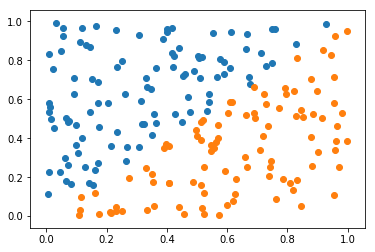

In [3]:
# Veri Uretelim
X = np.random.rand(200,2)
y = (X[:,0] > X[:,1]).astype('int')

plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])

In [4]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
start_time = timeit.default_timer()
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)
print("Time: ", timeit.default_timer() - start_time)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("\t\t\t\t\t---SKlearn Logistic Regression---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, y_pred))

Time:  0.0010560330119915307
					---SKlearn Logistic Regression---
confusion_matrix:
 [[22  0]
 [ 1 27]]
accuracy_score:  0.98


In [5]:
classifier.coef_, classifier.intercept_

(array([[ 4.02897715, -3.74510446]]), array([-0.21025854]))

In [6]:
# Fitting Our Own Neural Network to the Training set
from sklearn.linear_model import LogisticRegression
start_time = timeit.default_timer()
ysa = yapay_sinir_agi(katmanlar = [2,1])

agirlik, bias = ysa.ag()
print("agirlik matrisleri:")
for w in agirlik: print(w, "\n")
print("bias vektorleri:")
for b in bias: print(b, "\n")

ysa.fit(X_train,y_train, alpha = 0.2, number_steps = 100)
tahmin = ysa.predict(X_test)
print("Time: ", timeit.default_timer() - start_time)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, tahmin)
print("\t\t\t\t\t---Our Own Neural Network---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, tahmin))

agirlik matrisleri:
[[0.10817839 0.08435109]] 

bias vektorleri:
[[-0.01366696]] 

Time:  0.7392975279944949
					---Our Own Neural Network---
confusion_matrix:
 [[22  0]
 [ 0 28]]
accuracy_score:  1.0


In [7]:
agirlik, bias = ysa.ag()
print("agirlik matrisleri:")
for w in agirlik: print(w, "\n")
print("bias vektorleri:")
for b in bias: print(b, "\n")

agirlik matrisleri:
[[ 9.38980406 -8.93965483]] 

bias vektorleri:
[[-0.27660403]] 



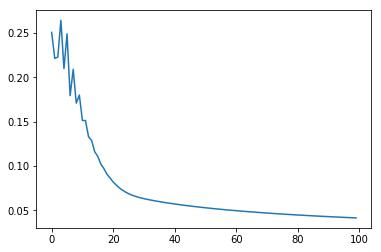

In [8]:
plt.plot(ysa.H)

agirlik matrisleri:
[[-0.02738148  0.08635043]] 

bias vektorleri:
[[0.11177522]] 

Time:  0.8037491830182262
					---Our Own Neural Network---
confusion_matrix:
 [[22  0]
 [ 0 28]]
accuracy_score:  1.0


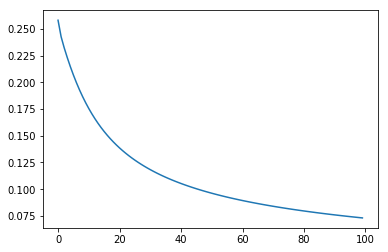

In [9]:
# Fitting Our Own Neural Network to the Training set
from sklearn.linear_model import LogisticRegression
start_time = timeit.default_timer()
ysa = yapay_sinir_agi(katmanlar = [2,1])

agirlik, bias = ysa.ag()
print("agirlik matrisleri:")
for w in agirlik: print(w, "\n")
print("bias vektorleri:")
for b in bias: print(b, "\n")

ysa.fit(X_train,y_train, alpha = 0.05, number_steps = 100)
tahmin = ysa.predict(X_test)
print("Time: ", timeit.default_timer() - start_time)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, tahmin)
print("\t\t\t\t\t---Our Own Neural Network---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, tahmin))
plt.plot(ysa.H)

agirlik matrisleri:
[[0.10418955 0.03304222]] 

bias vektorleri:
[[0.10002026]] 

Time:  0.7749624449643306
					---Our Own Neural Network---
confusion_matrix:
 [[22  0]
 [ 0 28]]
accuracy_score:  1.0


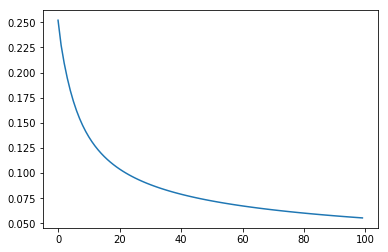

In [10]:
# Fitting Our Own Neural Network to the Training set
from sklearn.linear_model import LogisticRegression
start_time = timeit.default_timer()
ysa = yapay_sinir_agi(katmanlar = [2,1])

agirlik, bias = ysa.ag()
print("agirlik matrisleri:")
for w in agirlik: print(w, "\n")
print("bias vektorleri:")
for b in bias: print(b, "\n")

ysa.fit(X_train,y_train, alpha = 0.1, number_steps = 100)
tahmin = ysa.predict(X_test)
print("Time: ", timeit.default_timer() - start_time)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, tahmin)
print("\t\t\t\t\t---Our Own Neural Network---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, tahmin))
plt.plot(ysa.H)